
<h1> Computer Assignment 3 Report </h1>
<h2> Artificial Intelligence Course - University of Tehran - Fall 1400 </h2>
<h2> Naive Bayes Classifier </h2>
<h3> Name: Kianoush Arshi <br>
 Student ID: 810198438 </h3>

In this assignment, we'll be using a naive bayes classifier to classify a dataset of advertisements. There are six different classes:<br>
<li>Vehicles</li>
<li>Electronic devices</li>
<li>Businesses</li>
<li>For the home</li>
<li>Personal</li>
<li>Leisure & Hobbies</li>

In [1]:
import pandas as pd
import numpy as np
from operator import itemgetter
from matplotlib import pyplot as plt
from bidi.algorithm import get_display
from arabic_reshaper import reshape
from __future__ import unicode_literals
from hazm import *
from itertools import chain
import codecs

In [2]:
df = pd.read_csv("Data/divar_train.csv")
df

,title,description,categories
0,بلبل خرمایی,سه عدد بلبل خرمایی سه ماهه.از وقتی جوجه بودن خ...,leisure-hobbies
1,عینک اسکی در حد,عینک اسکی دبل لنز مارک يو وكس در حد نو اصلی م...,leisure-hobbies
2,تکیه سر تویوتا پرادو,پارچه ای سالم و تمیز.,vehicles
3,مجسمه کریستال24%,مجسمه دکوری کریستال بالرین Rcr24%,for-the-home
4,کیف و ساک,هر 2 کاملا تمیز هستند,personal
...,...,...,...
10195,ان هاش 85,نیمه دوم همه چی به شرط در حد خشک 260تا کار,vehicles
10196,405 دوگانه کارخانه. تمیز,فابریک 4 حلقه لاستیک 205 نو بیمه یکسال تخفیف ب...,vehicles
10197,بخاری گازی دودکش دار پلار,بخاری نو و بسیار تمیز هستش\nبا مشتری واقعی کنا...,for-the-home
10198,نر کله برنجی چتری,سلام به دلیل کمبود جا واسباب کشی به کمترین قیم...,leisure-hobbies


First, let's check the count of advertisements in each category:

In [3]:
df['categories'].value_counts()

leisure-hobbies       1700
vehicles              1700
for-the-home          1700
personal              1700
electronic-devices    1700
businesses            1700
Name: categories, dtype: int64

As mentioned in the project description, there are equal number of categories so ne resampling is needed.

<h2>Phase 1: Pre-processing the Data</h2>
<p>In this phase, the dataset is edited so that it'll be able to be used efficiently and correctly in the future. The changes made to the dataset include:</p>
<li>Stemming</li>
<li>Lemmatizing</li>
<li>Tokenizing</li>


<h3>Stemming and lemmatization</h3>

In [4]:
stemmer = Stemmer()
normalizer = Normalizer()
lemmatizer = Lemmatizer()

In [5]:
print(stemmer.stem(df['title'][0]))
print(stemmer.stem('خوابیدند'))
print(stemmer.stem('خوابید'))
print(stemmer.stem('خواب'))
print(stemmer.stem('بخوابی'))
print(stemmer.stem('خوابیدم'))

بلبل خرما
خوابیدند
خوابید
خواب
بخواب
خوابید


Stemmer reduces the words to the root word. This isn't very much useful for us since it removes some parts of the word.

In [6]:
print(lemmatizer.lemmatize(df['title'][0]))
print(lemmatizer.lemmatize('خوابیدند'))
print(lemmatizer.lemmatize('خوابید'))
print(lemmatizer.lemmatize('خواب'))
print(lemmatizer.lemmatize('بخوابی'))
print(lemmatizer.lemmatize('خوابیدم'))

بلبل خرمایی
خوابید#خواب
خوابید#خواب
خواب
خوابید#خواب
خوابید#خواب


Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meanings to one word. This is made possible by extracting principal parts of the verb. (bon e mazi # bon e mozare)
Lemmatization is the preferred method over Stemming.<br>

But for making use of lemmatization, we first need to tokenize the data:

In [7]:
print(word_tokenize(df['title'][0]))
print(word_tokenize(df['description'][0]))

['بلبل', 'خرمایی']
['سه', 'عدد', 'بلبل', 'خرمایی', 'سه', 'ماهه', '.', 'از', 'وقتی', 'جوجه', 'بودن', 'خودم', 'بزرگشون', 'کردم', 'اما', 'دستی', 'نیستن', 'واسه', 'همین', 'قیمت', 'پایین', 'دادم', '.', 'هر', 'سه', 'با', 'هم', '100', 'تومان', 'مقطوع', 'مقطوع']


The word_tokenize() function will breaks the sentence into it's words.<br>
This will prove useful in the future since we'll be using bag of words model in solving the problem.

In [8]:
print(word_tokenize(df['title'][0])[1])
print(lemmatizer.lemmatize(word_tokenize(df['title'][0])[1]))

خرمایی
خرما


We need to save stop words so that they are ignored. Also, some characters need to e removed and the data needs to be cleaned.

In [9]:
stop_file = codecs.open('stop_words.txt', encoding='utf-8')
stop_words = [lemmatizer.lemmatize(w) for w in stop_file.read().split('\n') if w]

stop_words.append('\r')
stop_words.append('\n')

stop_words = [x.strip() for x in stop_words]
stop_words[20:50]

['آخر',
 'آخرها',
 'آخه',
 'آدمهاست',
 'آرام',
 'آرام آرام',
 'آره',
 'آری',
 'آزادانه',
 'آسان',
 'آسیب پذیرند',
 'آشنایند',
 'آشکارا',
 'آقا',
 'آقای',
 'آقایان',
 'آمد',
 'آمدن',
 'آمده',
 'آمرانه',
 'آن',
 'آن گاه',
 'آنان',
 'آنانی',
 'آنجا',
 'آنرا',
 'آنطور',
 'آنقدر',
 'آنها',
 'آنهاست']

<h2>Phase 1: Problem Solving Process</h2>
<p>In this phase, we aim for solving the problem using Naive Bayes. As mentioned previously, bag of words model will be used for solving the problem. The feature used for classifying the advertisements is the number of words of each category used in the advertisement. The base formula used for classifying advertisements is as follows:</p><br>

$$P(c|x)=\frac{P(x|c)P(c)}{P(x)}$$

$x$: The word(s) detected<br>
$c$: Advertisement class<br>
$P(c|x)$: Probability of the current class being $c$ knowing that the word $x$ has appeared in the title and/or description. (Posterior)<br>
$P(x|c)$: Probability of seeing word $x$ in a class description of type $c$ (Likelihood)<br>
$P(c)$: Probability of seeing a book with genre $c$. This is equal for all genres since they all have occured the same number of times in the dataset. (Class Prior Probability)<br>
$P(x)$: Probability of seeing word $x$ in the context(Predictor Prior Probability (Evidence))<br>
Note that x can be viewed as multiple words which then we will have the fllwoing formula:<br>
$$P(c|X)=P(x_1|c)P(x_2|c)...P(x_n|c)P(c)$$

The process of solving this classifying problem is listeb below:<br>
<li> Tokenize the words (this can be unigram, bigram or ngram)
<li> Classify the tokenized words and calculate the given probabilities of the above formula (all except P(c|x) which will be tested on test dataset).
<li> Test the classifier.
<li> Calculate the accuracy.
<li> Repeat until we get an adequate accuracy.

Tokenizing the words:<br>
First, we'll tokenize the title column and use that as our feature only.<br>
We'll repeat this for description only and both title and description as features and choose the feature with best accuracy.<br>
This part is related with Grouping Operations technique [1].<br>


Bigrams and N-grams:<br>
This part relates to Feature Splitting technique of feature engineering. To know more about this technique, visit source [1].<br>
Note that using unigrams might increase inaccuracy of the model, for example check out the following snetences:<br>
I left my phone in the room.<br>
I'm left alone.<br>
Left here has two meanings and we need to know more than one word in order to figure out what left means.<br>
Persian example:<br>
<br>شیر امید را خورد
<br>امید شیر را خورد
<br>
This example is rather difficult! For this one, not only we need to check all the words, but also we need to check their order.<br>
In the first sentence, شیر means lion and the sentence translates to "The lion ate Omid". <br>
But in the second one, شیر means milk! The translation will be: "Omid drank the milk". <br>

Extracting data from train dataset:<br>
In this part we'll get the most occuring words in each category and store them in a dictionary so that we can use them for our test dataset.<br>
We'll have a dictionary which will have the key of a word/words and value of their occurance in the dictionary for their category.

In [10]:
def remove_stop_words(tokens: list()) -> list():
    for word in tokens:
        if word in stop_words:
            tokens.remove(word)
    return tokens

def plot_frequent_words(cats_dict, cats_total):
    categories = list(cats_total.keys())
    figure, axis = plt.subplots(nrows=len(categories), ncols=1, figsize=(15,15), constrained_layout=True)
    figure.supxlabel("Words in Ad")
    figure.supylabel("Occurance")
    for i in range(len(categories)):
        res = dict(sorted(cats_dict[categories[i]].items(), key = itemgetter(1), reverse = True)[:6])
        keys = res.keys()
        values = res.values()
        axis[i].bar([get_display(reshape(key)) for key in keys], values)
        axis[i].set_title(categories[i])

    plt.show()

In [11]:
# Ngram is used to know how many consecutive words we need to check.
# First we'll be only using title as our feature
def count_words(ngrams=1, use=['title']):
    # Total count of words in each category
    cats_total = dict(zip(df['categories'].unique(), [0 for i in range(len(df['categories'].unique()))]))
    print(cats_total)
    # List of category dictionaries
    cats_dict = dict(zip(df['categories'].unique(), [dict() for i in range(len(df['categories'].unique()))]))
    print(cats_dict)
    
    # Now, let's count the words...
    for ngram in range(1, ngrams+1):
        for index, row in df.iterrows(): # HOW CAN I MAKE THIS BETTER???
            tokens = list(chain.from_iterable([(remove_stop_words(word_tokenize(row[col_name]))) for col_name in use]))
            for i in range(len(tokens) - ngram+1):
                words = [lemmatizer.lemmatize(token) for token in tokens[i:i+ngram]]
                if (len(words) > 1):
                    ngram_word = ' '.join(words)
                else:
                    ngram_word = words[0]
                category = row['categories']
                cats_dict[category][ngram_word] = cats_dict[category].get(ngram_word, 0) + 1
                cats_total[category] += 1
                
    for cat in df['categories'].unique():
        cats_total[cat] -= cats_dict[cat]['.']
        del cats_dict[cat]['.']
                
    return cats_dict, cats_total

{'leisure-hobbies': 0, 'vehicles': 0, 'for-the-home': 0, 'personal': 0, 'electronic-devices': 0, 'businesses': 0}
{'leisure-hobbies': {}, 'vehicles': {}, 'for-the-home': {}, 'personal': {}, 'electronic-devices': {}, 'businesses': {}}


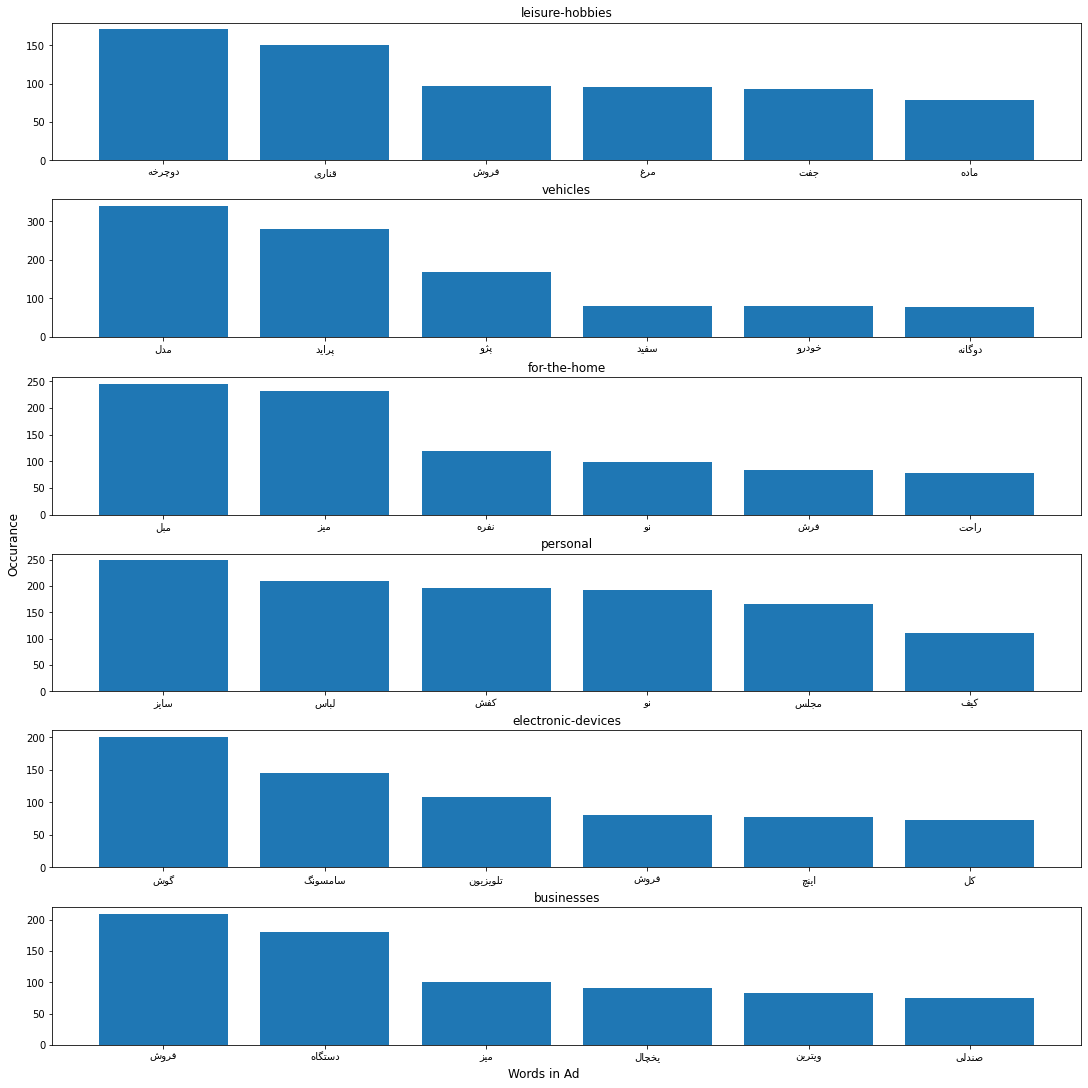

In [12]:
cats_dict, cats_total = count_words()
# Finally, let's plot the  6 most frequent words in each category:
plot_frequent_words(cats_dict, cats_total)

{'leisure-hobbies': 0, 'vehicles': 0, 'for-the-home': 0, 'personal': 0, 'electronic-devices': 0, 'businesses': 0}
{'leisure-hobbies': {}, 'vehicles': {}, 'for-the-home': {}, 'personal': {}, 'electronic-devices': {}, 'businesses': {}}


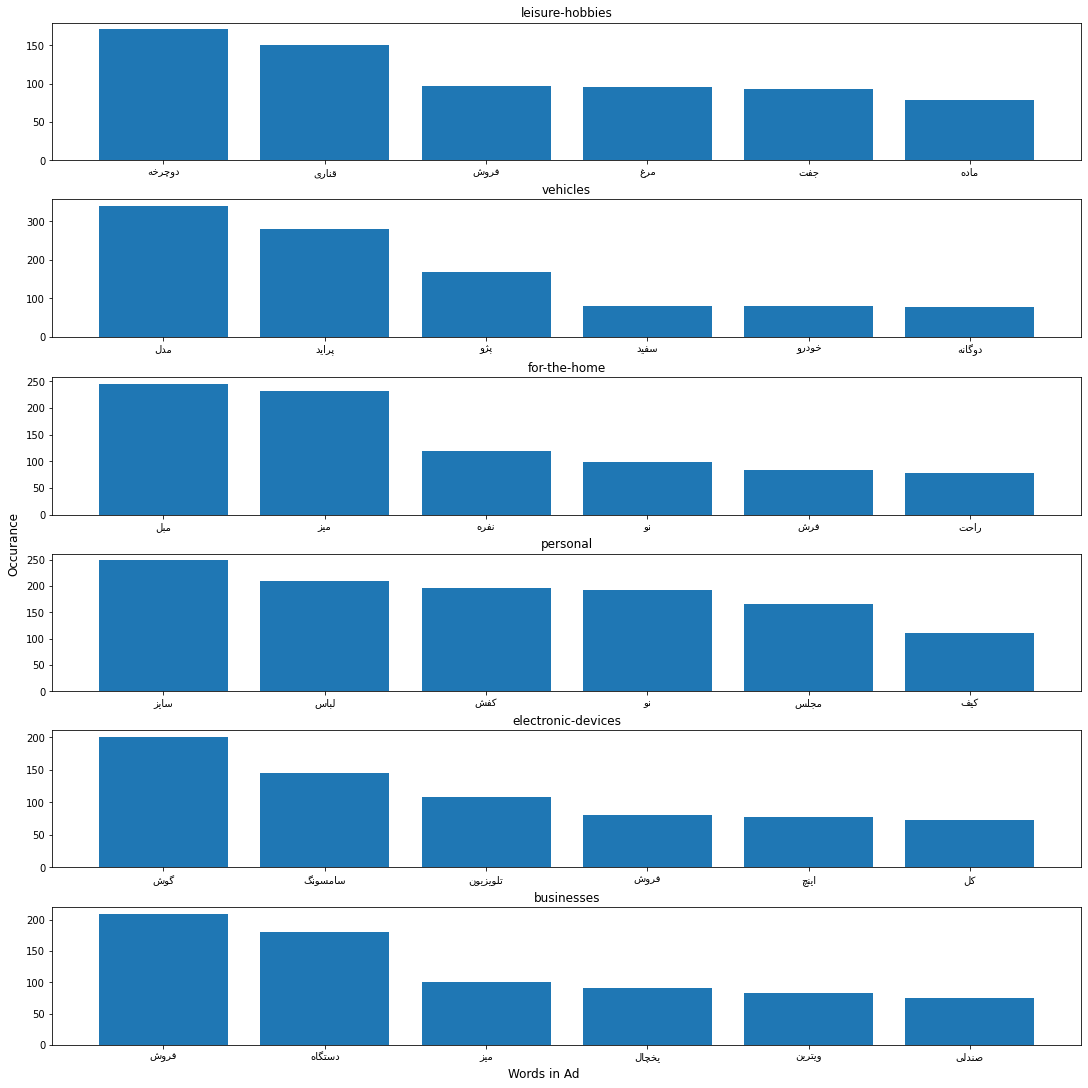

In [13]:
# Now let's try it with bigram model:
cats_dict, cats_total = count_words(ngrams=2)
plot_frequent_words(cats_dict, cats_total)

{'leisure-hobbies': 0, 'vehicles': 0, 'for-the-home': 0, 'personal': 0, 'electronic-devices': 0, 'businesses': 0}
{'leisure-hobbies': {}, 'vehicles': {}, 'for-the-home': {}, 'personal': {}, 'electronic-devices': {}, 'businesses': {}}


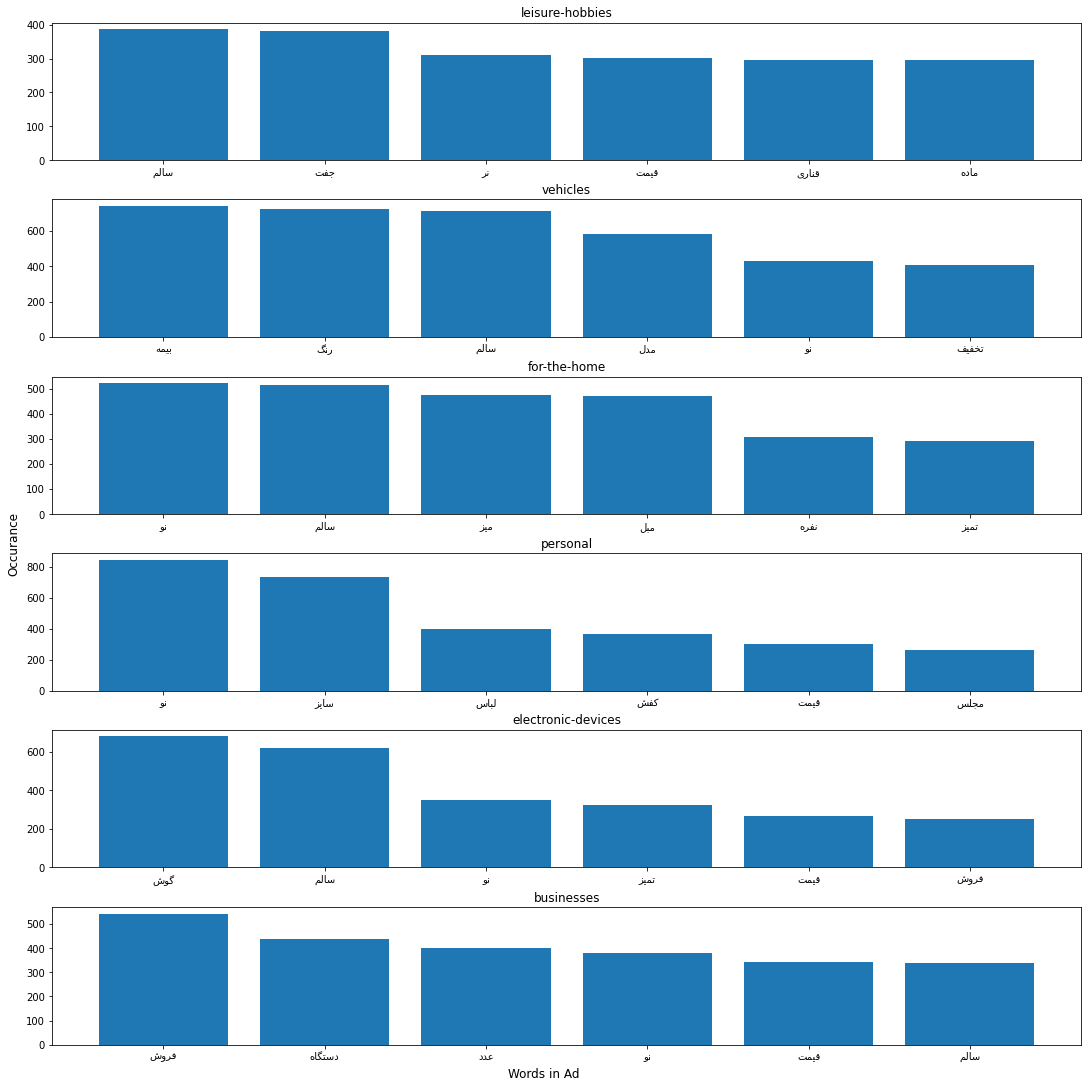

In [14]:
# And let's add description to the equation:
cats_dict, cats_total = count_words(ngrams=1, use=["title", "description"])
plot_frequent_words(cats_dict, cats_total)

As you can see above, the word "نو" is the most occured word in both personal and for-the-home categories. so we should probably remove it.<br>
Some other words are also used too much.<br>
There is another problem which is related to lemmatizing, in the electronics category the most occured word is "گوش" which should be "گوشی" but since this word isn't very much used in other categories, we'll ignore it for now.


In [15]:
stop_words.append("نو")
stop_words.append("یک")
stop_words.append("قیمت")
stop_words.append("سالم")

{'leisure-hobbies': 0, 'vehicles': 0, 'for-the-home': 0, 'personal': 0, 'electronic-devices': 0, 'businesses': 0}
{'leisure-hobbies': {}, 'vehicles': {}, 'for-the-home': {}, 'personal': {}, 'electronic-devices': {}, 'businesses': {}}


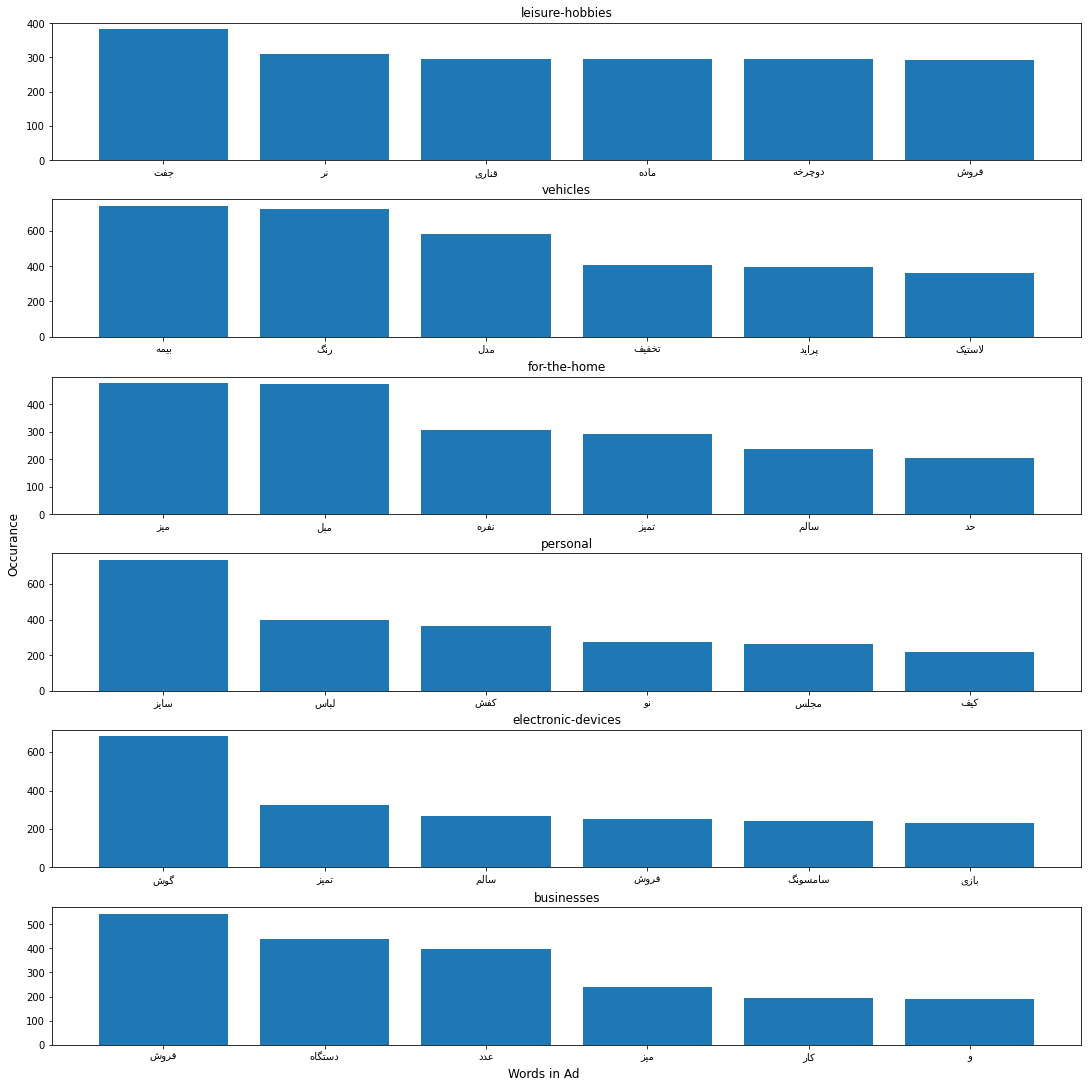

In [16]:
# Now, let's try again with the removed word:
cats_dict, cats_total = count_words(ngrams=1, use=["title", "description"])
plot_frequent_words(cats_dict, cats_total)

Now, let's get the test file and start the classification

In [17]:
test_df = pd.read_csv("Data/divar_test.csv")
test_df.head(5)

,title,description,categories
0,کیف مجلسی نو,کیف مجلسی نوی نو,personal
1,دیوار کوب نمدی تزیینی,مناسب برای جهاز عروس,for-the-home
2,دو تیکه بسیار بسیار تمیز و سالم,با کشوی مخفی و شیک,for-the-home
3,مودم,سلام مودم سالم با وسایلش،دیگه ب کارم نمیاد \nم...,electronic-devices
4,تعداد18عددبوقلمون به قیمت عمده,سلام تعدای بوقلمون دارم به علت جابه جایی به فر...,leisure-hobbies


<b>Problems of Naive Bayes:<br></b>
In case that there is word occured in only one type of genre, Naive Bayes will definetly choose that genre as the answer which might be wrong in some cases.

When word $x$ hasn't appeared in genre $c$, $P(x|c) = 0$ Because $log(0) = - \infty$ so the sum $ sum_{i=1}^{n} log(P(x_i | c)) $ will converge to $- \infty$ and never will be chosen as the genre since the algorithm chooses the genre which maximizes the above sum.<br>

The aforementioned problem can be solved using <b>additive smoothing</b>[3]. <br>
<b>Additive Smoothing:<br></b>
Additive smoothing associates the probability

$$P(\frac{WordCount+\alpha}{TotalWords + \alpha+D})$$

Where $\alpha$ is a positive constant and $D$ is the number of distinct words in the corresponding category.

rather than

$$P(\frac{WordCount}{TotalWords})$$

with $P(Word|c)$

Without additive smoothing, $\alpha$ is 0

This will avoid the $- \infty$ problem mentioned in the problem since the fraction will never be equal to 0 because of the positive $\alpha$ in the numerator.




Back to the topic of classifying.<br>
Note: We must encode our categories by mapping them to 0 to 5.<br>

There are 3 features that we can use for the prediction.

<li> Using ad's title

<li> Using ad's description

<li> Using ad's both title and description
    
We can assume the last option gives the best accuracy, but we'll check them all out

In [18]:
# Utility function to calcullate required probabilities
from math import log

ZERO = 10**-32

def calculate_probabilities(sentence, cats_occurance, cats_total, ngrams=1, alpha=0):
    # Dictionary to hold category probabilities of a sentence
    probs = dict(zip(df['categories'].unique(), [0 for i in range(len(df['categories'].unique()))]))
    
    for ngram in range(1, ngrams+1):
        tokens = remove_stop_words(word_tokenize(sentence))
        for i in range(len(tokens) - ngram+1):
            words = [lemmatizer.lemmatize(token) for token in tokens[i:i+ngram]]
            for ngram_word in words:
                if ngram_word == ".":
                    continue

                for category in probs.keys():
                    D = len(list(cats_occurance[category].keys()))
                    if not ngram_word in cats_occurance[category] and alpha==0:
                        probs[category] += log(ZERO)
                    else:
                        probs[category] += log((cats_occurance[category].get(ngram_word, 0) + alpha) / (cats_total[category] + alpha+D))
    return probs

<h3> Phase 3: Testing </h3>
Now we'll test our algorithms accuracy and see if we can improve it or not.<br>
In order to test it we'll need to check the following criteria:<br>
<li> Accuracy<br>
    $$\text{Accuracy} = \frac{\text{Correct Detected}}{\text{Total}}$$<br>
    
<li> Precision<br>
$$\text{Precision} = \frac{\text{Correct Detected Class}}{\text{All Detected Class}}$$<br>
    
<li> Recall<br>
$$\text{Recall} = \frac{\text{Correct Detected Class}}{\text{Total Class}}$$<br>
  
<li> F1<br>
$$\text{F1} = 2\times\frac{\text{Precision}\times\text{Recall}}{\text{Precision}+\text{Recall}}$$<br>
    
<br>
<b>Why we use both precision and recall in checking the algorithm</b>:<br>
    
1. If the classifier always predicts personal for an ad's category, the recall value for the class personal will be 100% which will inform us that the model isn't adequate.<br>

2. There might be a case that we only have 2 predictions for the personal class out of a total number of 500000 predictions. The probability of making a mistake in two predictions would be so low because we made only 2 predictions. So this might lead to a 100% precision and a low recall because of missing many other instances of personal ads.
    
    
    
    
<b>F1 Score [5]:<br></b>
F1 score is the harmonic mean of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall.
    
    
    
    
<b>Multi-Class Metrics [6]</b>:<br>
In this model, we have three different types of averaging methods:<br>
    
<li> Micro: Calculates F1 by value total true positives, false negatives and false positives no matter the prediction for each label in the dataset.<br>
Based on source [8] the formula for calculating micro average is:
$$\text{Micro-F1} = \frac{\text{correct_detected}}{\text{all_detected}}$$
<br>

<li> Macro: Calculates F1 for each label, and returns the average without considering the proportion for each label in the dataset.<br>
$$\text{Macro-F1} = \frac{F_{1,1}+\dots+F_{1,n}}{n}$$
<br>

<li> Weighted: Calculates F1 for each label, and returns the average considering the proportion for each label in the dataset.<br>
$$\text{Weighted-F1} = P(C_1)F_{1,1}+\dots+P(C_n)F_{1,n}$$
<br>
Since our categories are balanced, the result of weighted and macro averages won't be different
    
    
    
<br>
Now, we'll implement the Naive Bayes model on the test dataframe:

In [19]:
# Get variables used in getting precision
def get_assessment_variables(cats_dict, cats_total, ngrams=1, use=["title"], alpha=0):
    wrong_df = pd.DataFrame(columns=['title', 'description', 'categories', 'wrong categories'])
    correct_detected_class = dict(zip(df['categories'].unique(), [0 for i in range(len(df['categories'].unique()))]))
    all_detected_class = dict(zip(df['categories'].unique(), [0 for i in range(len(df['categories'].unique()))]))
    total_class = dict(zip(df['categories'].unique(), [0 for i in range(len(df['categories'].unique()))]))
    correct = 0
    
    for index, row in test_df.iterrows(): # FIX THIS!
        probs = calculate_probabilities(' '.join([row[col_name] for col_name in use]), cats_dict, cats_total, ngrams, alpha)

        # Predict category using maximum probability
        predict = max(probs, key=probs.get)

        if (row['categories'] == predict):
            correct += 1
            correct_detected_class[predict] += 1
        else:
            name = row.name
            row = row.append(pd.Series([predict], index=['wrong categories']))
            row = row.rename(name)
            wrong_df = wrong_df.append(row)
        all_detected_class[predict] += 1
        total_class[row['categories']] += 1
        
    return correct_detected_class, all_detected_class, total_class, correct, wrong_df

def print_results(cats_dict, test_df, correct, correct_detected_class, all_detected_class, total_class):
    Precision = dict(zip(cats_dict.keys(), [0 for i in range(len(cats_dict.keys()))]))
    Recall = dict(zip(cats_dict.keys(), [0 for i in range(len(cats_dict.keys()))]))
    F1 = dict(zip(cats_dict.keys(), [0 for i in range(len(cats_dict.keys()))]))
    print("Accuracy = ", (correct / len(test_df)))
    print("Precision, Recall, and F1 for the categories are:")
    print()

    for category in cats_dict.keys():
        Precision[category] = correct_detected_class[category] / all_detected_class[category]
        Recall[category] = correct_detected_class[category] / total_class[category]
        F1[category] = (2 * Precision[category] * Recall[category]) / (Precision[category] + Recall[category])

        print("Category ", category)
        print("Correct Detected Class: ", correct_detected_class[category])
        print("All Detected Class: ", all_detected_class[category])
        print("Total Class: ", total_class[category])
        print("Precision = ", Precision[category])
        print("Recall = ", Recall[category])
        print("F1 = ", F1[category])
        print()
        
    print("Micro Avg = ", correct/sum(all_detected_class.values()))
    print("Macro Avg = ", sum(F1.values())/len(cats_dict.keys()))
    print("Weighted Avg = ", sum([F1[cat]*(total_class[cat]/sum(total_class.values())) for cat in cats_dict.keys()]))

In [20]:
# Count words, with ngram=1 and using title feature only
use_cols = ["title"]
cats_dict, cats_total = count_words(use=use_cols)
# Calculate assessment variables with ngrams =1, using title column only and no additive smoothing
correct_detected_class, all_detected_class, total_class, correct, wrong_df = get_assessment_variables(cats_dict, cats_total, use=use_cols)

print("Results without additive smoothing and title only:")
print()
print_results(cats_dict, test_df, correct, correct_detected_class, all_detected_class, total_class)

{'leisure-hobbies': 0, 'vehicles': 0, 'for-the-home': 0, 'personal': 0, 'electronic-devices': 0, 'businesses': 0}
{'leisure-hobbies': {}, 'vehicles': {}, 'for-the-home': {}, 'personal': {}, 'electronic-devices': {}, 'businesses': {}}
Results without additive smoothing and title only:

Accuracy =  0.8266666666666667
Precision, Recall, and F1 for the categories are:

Category  leisure-hobbies
Correct Detected Class:  249
All Detected Class:  323
Total Class:  300
Precision =  0.7708978328173375
Recall =  0.83
F1 =  0.7993579454253611

Category  vehicles
Correct Detected Class:  266
All Detected Class:  294
Total Class:  300
Precision =  0.9047619047619048
Recall =  0.8866666666666667
F1 =  0.8956228956228958

Category  for-the-home
Correct Detected Class:  239
All Detected Class:  299
Total Class:  300
Precision =  0.7993311036789298
Recall =  0.7966666666666666
F1 =  0.7979966611018364

Category  personal
Correct Detected Class:  258
All Detected Class:  297
Total Class:  300
Precision 

We're close but not quite there, notice that the business category, leisure-hobbies and for-the-home category are the worst of the bunch.<br>
Now, let's check the results with additive smoothing and $\alpha = 1$:

In [21]:
# Count words, with ngram=1 and using title feature only =
use_cols = ["title"]
cats_dict, cats_total = count_words(use=use_cols)
# Calculate assessment variables with ngrams=1, using title column only this time with additive smoothing
correct_detected_class, all_detected_class, total_class, correct, wrong_df = get_assessment_variables(cats_dict, cats_total, alpha=1, use=use_cols)

print("Results with additive smoothing and title only:")
print()
print_results(cats_dict, test_df, correct, correct_detected_class, all_detected_class, total_class)

{'leisure-hobbies': 0, 'vehicles': 0, 'for-the-home': 0, 'personal': 0, 'electronic-devices': 0, 'businesses': 0}
{'leisure-hobbies': {}, 'vehicles': {}, 'for-the-home': {}, 'personal': {}, 'electronic-devices': {}, 'businesses': {}}
Results with additive smoothing and title only:

Accuracy =  0.8155555555555556
Precision, Recall, and F1 for the categories are:

Category  leisure-hobbies
Correct Detected Class:  230
All Detected Class:  263
Total Class:  300
Precision =  0.8745247148288974
Recall =  0.7666666666666667
F1 =  0.8170515097690942

Category  vehicles
Correct Detected Class:  257
All Detected Class:  293
Total Class:  300
Precision =  0.8771331058020477
Recall =  0.8566666666666667
F1 =  0.866779089376054

Category  for-the-home
Correct Detected Class:  261
All Detected Class:  386
Total Class:  300
Precision =  0.6761658031088082
Recall =  0.87
F1 =  0.760932944606414

Category  personal
Correct Detected Class:  262
All Detected Class:  309
Total Class:  300
Precision =  0.

Strange, usually with the addition of additive smoothing to our equation, the accuracy increases. But in this case it decreases. The reasin behind this is....<br>
Also, note that this time, only business and for-the-home categories are the least accurate ones. This conclusion is based on their F1 score.

In [22]:
# Count words, with ngram=1 and using description feature only
use_cols = ["description"]
cats_dict, cats_total = count_words(use=use_cols)
# Calculate assessment variables with ngrams=1, using description column only with no additive smoothing
correct_detected_class, all_detected_class, total_class, correct, wrong_df = get_assessment_variables(cats_dict, cats_total, use=use_cols)

print("Results without additive smoothing and description only:")
print()
print_results(cats_dict, test_df, correct, correct_detected_class, all_detected_class, total_class)

{'leisure-hobbies': 0, 'vehicles': 0, 'for-the-home': 0, 'personal': 0, 'electronic-devices': 0, 'businesses': 0}
{'leisure-hobbies': {}, 'vehicles': {}, 'for-the-home': {}, 'personal': {}, 'electronic-devices': {}, 'businesses': {}}
Results without additive smoothing and description only:

Accuracy =  0.735
Precision, Recall, and F1 for the categories are:

Category  leisure-hobbies
Correct Detected Class:  230
All Detected Class:  301
Total Class:  300
Precision =  0.7641196013289037
Recall =  0.7666666666666667
F1 =  0.7653910149750416

Category  vehicles
Correct Detected Class:  236
All Detected Class:  286
Total Class:  300
Precision =  0.8251748251748252
Recall =  0.7866666666666666
F1 =  0.8054607508532423

Category  for-the-home
Correct Detected Class:  196
All Detected Class:  289
Total Class:  300
Precision =  0.6782006920415224
Recall =  0.6533333333333333
F1 =  0.66553480475382

Category  personal
Correct Detected Class:  214
All Detected Class:  284
Total Class:  300
Preci

In [23]:
# Count words, with ngram=1 and using description feature onl
use_cols = ["description"]
cats_dict, cats_total = count_words(use=use_cols)
# Calculate assessment variables with ngrams=1, using description column only this time with additive smoothing
correct_detected_class, all_detected_class, total_class, correct, wrong_df = get_assessment_variables(cats_dict, cats_total, alpha=1, use=use_cols)

print("Results with additive smoothing and description only:")
print()
print_results(cats_dict, test_df, correct, correct_detected_class, all_detected_class, total_class)

{'leisure-hobbies': 0, 'vehicles': 0, 'for-the-home': 0, 'personal': 0, 'electronic-devices': 0, 'businesses': 0}
{'leisure-hobbies': {}, 'vehicles': {}, 'for-the-home': {}, 'personal': {}, 'electronic-devices': {}, 'businesses': {}}
Results with additive smoothing and description only:

Accuracy =  0.7572222222222222
Precision, Recall, and F1 for the categories are:

Category  leisure-hobbies
Correct Detected Class:  214
All Detected Class:  247
Total Class:  300
Precision =  0.8663967611336032
Recall =  0.7133333333333334
F1 =  0.7824497257769654

Category  vehicles
Correct Detected Class:  245
All Detected Class:  287
Total Class:  300
Precision =  0.8536585365853658
Recall =  0.8166666666666667
F1 =  0.8347529812606473

Category  for-the-home
Correct Detected Class:  234
All Detected Class:  385
Total Class:  300
Precision =  0.6077922077922078
Recall =  0.78
F1 =  0.6832116788321169

Category  personal
Correct Detected Class:  234
All Detected Class:  321
Total Class:  300
Precisi

As you can see, we don't have a good accuracy for any of the above approaches.<br>
Using the description feature, things got even worse!<br>
Let's try both title and decription together and see the results:

In [24]:
# Count words, with ngram=1 and using description and title
use_cols = ["title", "description"]
cats_dict, cats_total = count_words(use=use_cols)
# Calculate assessment variables with ngrams=1, using title and description columns with no additive smoothing
correct_detected_class, all_detected_class, total_class, correct, wrong_df = get_assessment_variables(cats_dict, cats_total, use=use_cols)

print("Results without additive smoothing and description only:")
print()
print_results(cats_dict, test_df, correct, correct_detected_class, all_detected_class, total_class)

{'leisure-hobbies': 0, 'vehicles': 0, 'for-the-home': 0, 'personal': 0, 'electronic-devices': 0, 'businesses': 0}
{'leisure-hobbies': {}, 'vehicles': {}, 'for-the-home': {}, 'personal': {}, 'electronic-devices': {}, 'businesses': {}}
Results without additive smoothing and description only:

Accuracy =  0.8305555555555556
Precision, Recall, and F1 for the categories are:

Category  leisure-hobbies
Correct Detected Class:  248
All Detected Class:  292
Total Class:  300
Precision =  0.8493150684931506
Recall =  0.8266666666666667
F1 =  0.8378378378378378

Category  vehicles
Correct Detected Class:  266
All Detected Class:  295
Total Class:  300
Precision =  0.9016949152542373
Recall =  0.8866666666666667
F1 =  0.8941176470588236

Category  for-the-home
Correct Detected Class:  233
All Detected Class:  287
Total Class:  300
Precision =  0.8118466898954704
Recall =  0.7766666666666666
F1 =  0.7938671209540034

Category  personal
Correct Detected Class:  251
All Detected Class:  290
Total Cl

This looks promising.<br>
What if we use additive smoothing?

In [25]:
# Count words, with ngram=1 and using description and title
use_cols = ["title", "description"]
cats_dict, cats_total = count_words(use=use_cols)
# Calculate assessment variables with ngrams=1, using title and description columns with additive smoothing
correct_detected_class, all_detected_class, total_class, correct, wrong_df = get_assessment_variables(cats_dict, cats_total, alpha=1, use=use_cols)

print("Results with additive smoothing and description only:")
print()
print_results(cats_dict, test_df, correct, correct_detected_class, all_detected_class, total_class)

{'leisure-hobbies': 0, 'vehicles': 0, 'for-the-home': 0, 'personal': 0, 'electronic-devices': 0, 'businesses': 0}
{'leisure-hobbies': {}, 'vehicles': {}, 'for-the-home': {}, 'personal': {}, 'electronic-devices': {}, 'businesses': {}}
Results with additive smoothing and description only:

Accuracy =  0.8666666666666667
Precision, Recall, and F1 for the categories are:

Category  leisure-hobbies
Correct Detected Class:  248
All Detected Class:  268
Total Class:  300
Precision =  0.9253731343283582
Recall =  0.8266666666666667
F1 =  0.8732394366197183

Category  vehicles
Correct Detected Class:  272
All Detected Class:  289
Total Class:  300
Precision =  0.9411764705882353
Recall =  0.9066666666666666
F1 =  0.9235993208828523

Category  for-the-home
Correct Detected Class:  269
All Detected Class:  350
Total Class:  300
Precision =  0.7685714285714286
Recall =  0.8966666666666666
F1 =  0.8276923076923077

Category  personal
Correct Detected Class:  272
All Detected Class:  315
Total Class

This is great!<br>
Let's try to decrease $\alpha$. Based on source[3], $\alpha < 1$ is used more often in practice.<br>
Note: Read more about additive smoothing and the reason behind choosing the best $\alpha$ <a href="https://www.analyticsvidhya.com/blog/2021/04/improve-naive-bayes-text-classifier-using-laplace-smoothing/">here</a>.

In [26]:
# Count words, with ngram=1 and using description and title
use_cols = ["title", "description"]
cats_dict, cats_total = count_words(use=use_cols)

{'leisure-hobbies': 0, 'vehicles': 0, 'for-the-home': 0, 'personal': 0, 'electronic-devices': 0, 'businesses': 0}
{'leisure-hobbies': {}, 'vehicles': {}, 'for-the-home': {}, 'personal': {}, 'electronic-devices': {}, 'businesses': {}}


In [27]:
# Calculate assessment variables with ngrams=1, using title and description columns with additive smoothing
correct_detected_class, all_detected_class, total_class, correct, wrong_df = get_assessment_variables(cats_dict, cats_total, alpha=0.5, use=use_cols)

print("Results with additive smoothing and description only:")
print()
print_results(cats_dict, test_df, correct, correct_detected_class, all_detected_class, total_class)

Results with additive smoothing and description only:

Accuracy =  0.8716666666666667
Precision, Recall, and F1 for the categories are:

Category  leisure-hobbies
Correct Detected Class:  251
All Detected Class:  269
Total Class:  300
Precision =  0.9330855018587361
Recall =  0.8366666666666667
F1 =  0.8822495606326889

Category  vehicles
Correct Detected Class:  273
All Detected Class:  290
Total Class:  300
Precision =  0.9413793103448276
Recall =  0.91
F1 =  0.9254237288135593

Category  for-the-home
Correct Detected Class:  267
All Detected Class:  339
Total Class:  300
Precision =  0.7876106194690266
Recall =  0.89
F1 =  0.8356807511737089

Category  personal
Correct Detected Class:  270
All Detected Class:  311
Total Class:  300
Precision =  0.8681672025723473
Recall =  0.9
F1 =  0.8837970540098199

Category  electronic-devices
Correct Detected Class:  275
All Detected Class:  296
Total Class:  300
Precision =  0.9290540540540541
Recall =  0.9166666666666666
F1 =  0.9228187919463

The accuracy is increased even more. So there must be a perfect $\alpha$ where we'll get the highest accuracy increase using additive smoothing.<br>


Now, let's check out some of our wrong predictions:<br>


In [28]:
wrong_df

,title,description,categories,wrong categories
16,سیپوراکس,سیپوراکس میکرو مک جی بی ال و سرامیک سرا ، کاهن...,leisure-hobbies,for-the-home
28,موتور تزیینی,از جنس اهن کار دست عرضه به صورت عمده و تکی,for-the-home,businesses
37,90عدد بشقاب پیتزا تک نفره قیمت هرعدد 4000,بشقاب پیتزا یک نفره عددی 4000 باتشکراز دیوار.,businesses,for-the-home
49,اچارشلاقی HEYCOالمان,اصل المان \nسایز ۱/۵\nبسیار مقاوم,businesses,personal
50,فروش تلفکس,سلام.تلفکس پاناسونیک.تمیز و کم کار,businesses,electronic-devices
...,...,...,...,...
1762,سشوار صنعتی متابو اصل,متابو اصل سالم,businesses,personal
1768,فکس T...Come ، تی کام اصل آلمان,فکس T... Come اصل ... در منزل استفاده شده . نو...,businesses,electronic-devices
1770,دو قواره پارچه چادری3/5متری,دو قواره پارچه چادر 3/5متری مناسب برای عیدی دا...,personal,for-the-home
1771,زیر پایی,باسلام فروش زیر پایی کاسه ای کاملاً نوع وتازه...,vehicles,for-the-home


As mentioned before, most of our errors are related to for-the-home and business categories. This is partially because of our pre processing and the nature of these two categories. If we take a look at the most occured words in these two categories, we'll see that these two have the most number of words that have occured in other categories which is one of the reasons why they are the least accurate. So we might fix our pre processing by adding more stop words or checking some other features. Also, some characters aren't removed like '\n'.<br>



<h3> Bonus: </h3>

Let's try another approach. This time instead of using unigram model only, we'll use unigram and bigram words to classify our advertisements.<br>

In [31]:
# Count words, with ngram=1 and using description and title
use_cols = ["title", "description"]
cats_dict, cats_total = count_words(ngrams=2, use=use_cols)

{'leisure-hobbies': 0, 'vehicles': 0, 'for-the-home': 0, 'personal': 0, 'electronic-devices': 0, 'businesses': 0}
{'leisure-hobbies': {}, 'vehicles': {}, 'for-the-home': {}, 'personal': {}, 'electronic-devices': {}, 'businesses': {}}


In [32]:
# Calculate assessment variables with ngrams=1, using title and description columns with additive smoothing
correct_detected_class, all_detected_class, total_class, correct, wrong_df = get_assessment_variables(cats_dict, cats_total, ngrams=2, alpha=0.5, use=use_cols)

print("Results with additive smoothing and description only:")
print()
print_results(cats_dict, test_df, correct, correct_detected_class, all_detected_class, total_class)

Results with additive smoothing and description only:

Accuracy =  0.8661111111111112
Precision, Recall, and F1 for the categories are:

Category  leisure-hobbies
Correct Detected Class:  250
All Detected Class:  268
Total Class:  300
Precision =  0.9328358208955224
Recall =  0.8333333333333334
F1 =  0.8802816901408451

Category  vehicles
Correct Detected Class:  273
All Detected Class:  291
Total Class:  300
Precision =  0.9381443298969072
Recall =  0.91
F1 =  0.9238578680203046

Category  for-the-home
Correct Detected Class:  267
All Detected Class:  342
Total Class:  300
Precision =  0.7807017543859649
Recall =  0.89
F1 =  0.8317757009345794

Category  personal
Correct Detected Class:  267
All Detected Class:  309
Total Class:  300
Precision =  0.8640776699029126
Recall =  0.89
F1 =  0.8768472906403941

Category  electronic-devices
Correct Detected Class:  271
All Detected Class:  294
Total Class:  300
Precision =  0.9217687074829932
Recall =  0.9033333333333333
F1 =  0.912457912457

<h3>References:</h3><br><br>
[1] https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114<br>
[2] https://www.sciencedirect.com/science/article/pii/S1319157818303823<br>
[3] https://en.wikipedia.org/wiki/Additive_smoothing<br>
[4] https://medium.com/@amirashabani/pie-chart-and-persian-language-in-python-68dfd03a26fb<br>
[5] https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/<br>
[6] https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1<br>
[7] https://www.researchgate.net/publication/221420084_Effective_Methods_for_Improving_Naive_Bayes_Text_Classifiers<br>
[8] https://androidkt.com/micro-macro-averages-for-imbalance-multiclass-classification/<br>
[9] https://github.com/kharazi/persian-stopwords<br>
